In [228]:
import numpy as np
import pandas as pd
import string
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import missingno


# data preprocessing 
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# model selection & validation
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score

import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt


from sklearn.model_selection import RandomizedSearchCV



# model import 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    VotingClassifier,
    StackingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor
)

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# evaluation 
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)


RSEED = 42


import string
import warnings
import missingno
warnings.filterwarnings('ignore')

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_all = pd.concat((df_train, df_test)).reset_index(drop=True)


from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")


In [254]:
# print(df_train.shape)
# print(df_train.dtypes)

In [258]:
# df_train.info()

In [259]:
# missingno.matrix(df_train)

In [260]:
cat_cols = df_train.select_dtypes(include='category').columns
for col in cat_cols:
    df_train[col] = df_train[col].str.strip().str.lower()

In [261]:
df_train['travel_with'] = df_train['travel_with'].str.lower().str.strip()

# feature engineering


In [262]:
def preprocess_data(df, is_train=True):
    df = df.copy()

    
    df['total_female'] = df['total_female'].fillna(0)
    df['total_male'] = df['total_male'].fillna(0)
    df['travel_with'] = df['travel_with'].fillna('alone')

   
    df['group_size'] = df['total_female'] + df['total_male']
    df['total_nights'] = df['night_mainland'] + df['night_zanzibar']

    package_cols = [
        'tour_arrangement',
        'package_transport_int',
        'package_accomodation',
        'package_food',
        'package_transport_tz',
        'package_sightseeing',
        'package_guided_tour',
        'package_insurance'
    ]

    def compute_package_score(row):
        score = 0
        val = row['tour_arrangement']
        if pd.notnull(val):
            if 'package' in val.lower() or 'agency' in val.lower():
                score += 1
        for col in package_cols[1:]:
            val = row[col]
            if pd.notnull(val) and str(val).strip().lower() == 'yes':
                score += 1
        return score

    df['package_score'] = df.apply(compute_package_score, axis=1)

    
    if is_train and 'total_cost' in df.columns:
        df['cost_group'] = pd.qcut(
            df['total_cost'],
            q=3,
            labels=['low_cost_spender', 'middle_cost_spender', 'high_cost_spender']
        )

    return df


In [263]:
df_train = preprocess_data(df_train, is_train=True)
df_test = preprocess_data(df_test, is_train=False)


In [266]:
# sns.scatterplot(x='night_mainland', y='total_cost', data=df_train)

In [265]:
# df_train.isna().sum()

In [239]:
df_train['cost_group'] = pd.qcut(df_train['total_cost'], q=3, labels=['low_cost_spender', 'middle_cost_spender', 'high_cost_spender'])
# print(df_train['cost_group'].value_counts())

In [240]:
cross = pd.crosstab(df_train['package_score'], df_train['cost_group'], normalize='index')
# print(cross)

In [241]:
high_df = df_train[df_train['cost_group'] == 'high_cost_spender']

In [267]:
total_revenue = df_train['total_cost'].sum()
high_revenue = df_train[df_train['cost_group'] == 'high_cost_spender']['total_cost'].sum()
high_share = (high_revenue / total_revenue) * 100
print(high_share) # percent 

80.70359466004514


In [243]:
# Analyze the characteristics of the top 30% of users who spend the most money.
high_df = df_train[df_train['cost_group'] == 'high_cost_spender']
for col in high_df.columns:
    if col in ['cost_group']: 
        continue

    print(f"\n📌 Top 5 in '{col}' for high_cost_spender:")
    top_values = high_df[col].value_counts(normalize=True).head(5) * 100
    print(top_values.round(2).astype(str) + ' %')


📌 Top 5 in 'ID' for high_cost_spender:
ID
tour_1002    0.06 %
tour_1013    0.06 %
tour_1017    0.06 %
tour_1029    0.06 %
tour_1035    0.06 %
Name: proportion, dtype: object

📌 Top 5 in 'country' for high_cost_spender:
country
UNITED STATES OF AMERICA    23.36 %
ITALY                       13.24 %
FRANCE                       9.93 %
UNITED KINGDOM               9.06 %
AUSTRALIA                    6.93 %
Name: proportion, dtype: object

📌 Top 5 in 'age_group' for high_cost_spender:
age_group
25-44    39.91 %
45-64    39.85 %
65+      13.24 %
1-24       7.0 %
Name: proportion, dtype: object

📌 Top 5 in 'travel_with' for high_cost_spender:
travel_with
spouse                 37.04 %
friends/relatives      22.55 %
alone                  19.93 %
spouse and children    15.87 %
children                4.62 %
Name: proportion, dtype: object

📌 Top 5 in 'total_female' for high_cost_spender:
total_female
1.0    61.96 %
2.0    15.93 %
0.0    11.87 %
3.0     6.06 %
4.0     1.56 %
Name: proportion,

In [244]:
df_train = df_train.drop(columns=["ID", "info_source", "most_impressing"])

# Splite X,y

In [245]:
# df_train.isna().sum()

In [246]:
q_high = df_train['total_cost'].quantile(0.99)
df_train = df_train[df_train['total_cost'] <= q_high]

y_train = np.log1p(df_train['total_cost']) 
X_train = df_train.drop('total_cost', axis=1)

X_test = df_test.drop('total_cost', axis=1, errors='ignore')  


In [247]:
# X_train.isna().sum()

# Tunning (XGBRegressor + GridSearchCV)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
✅ Best Params: {'regressor__colsample_bytree': 0.6, 'regressor__gamma': 0, 'regressor__learning_rate': 0.03, 'regressor__max_depth': 8, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
✅ Best MAE (CV): 0.05870013849192382
🧾 Best MAE (CV): 0.0587 (≈ 2,994,004 TZS)

📊 final outcome (Train focused)
MAE  : 2,994,004 TZS
RMSE : 5,802,290 TZS
MAPE : 90.53%
R²   : 0.5963


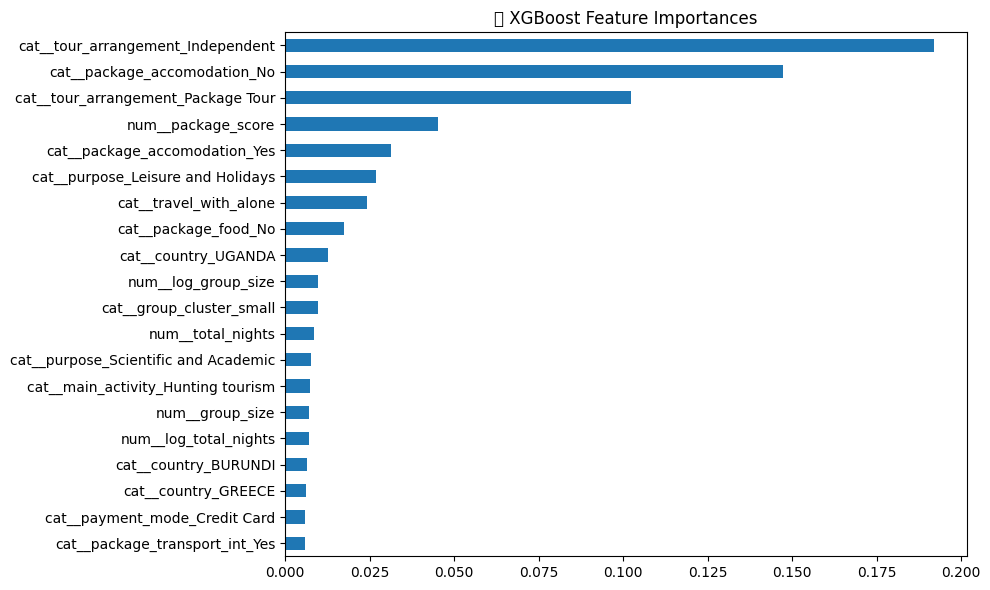

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.utils import compute_sample_weight
from xgboost import XGBRegressor


q_high = df_train['total_cost'].quantile(0.99)
df_train = df_train[df_train['total_cost'] <= q_high]


y_train = np.log1p(df_train['total_cost'])
X_train = df_train.drop(columns=['total_cost'], errors='ignore')
X_test = df_test.drop(columns=['total_cost'], errors='ignore')

drop_cols = ['total_cost', 'cost_group', 'cost_per_person', 'log_cost_per_person']

X_train = df_train.drop(columns=[col for col in drop_cols if col in df_train.columns])
X_test = df_test.drop(columns=[col for col in drop_cols if col in df_test.columns])

# new feature created  for x_train, x_test 
def add_features(df):
    df = df.copy()
    df['group_size'] = df['total_female'] + df['total_male']
    df['log_group_size'] = np.log1p(df['group_size'])
    df['total_nights'] = df['night_mainland'].fillna(0) + df['night_zanzibar'].fillna(0)
    df['log_total_nights'] = np.log1p(df['total_nights'])

    package_cols = [col for col in df.columns if col.startswith("package_")]
    numeric_package_cols = [col for col in package_cols if pd.api.types.is_numeric_dtype(df[col])]
    df['package_score'] = df[numeric_package_cols].sum(axis=1)

    df['female_ratio'] = df['total_female'] / (df['group_size'] + 1e-5)
    df['mainland_ratio'] = df['night_mainland'] / (df['total_nights'] + 1e-5)
    df['short_stay'] = (df['total_nights'] < 3).astype(int)

    df['group_cluster'] = pd.cut(df['group_size'], bins=[0, 2, 5, 10], labels=['small', 'mid', 'large'])

    return df


X_train = add_features(X_train)
X_test = add_features(X_test)


numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, cat_features)
])


reg = XGBRegressor(random_state=42, n_jobs=-1)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', reg)
])


param_dist = {
    'regressor__n_estimators': [200, 400],
    'regressor__max_depth': [8, 10, 12],
    'regressor__learning_rate': [0.05, 0.03, 0.01],
    'regressor__subsample': [0.8],
    'regressor__colsample_bytree': [0.6],
    'regressor__min_child_weight': [1, 3],
    'regressor__gamma': [0]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_dist,
    cv=3,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


y_pred_log = best_model.predict(X_train)
y_pred = np.expm1(y_pred_log)

mae = mean_absolute_error(df_train['total_cost'], y_pred)
rmse = np.sqrt(mean_squared_error(df_train['total_cost'], y_pred))
mape = mean_absolute_percentage_error(df_train['total_cost'], y_pred)
r2 = r2_score(df_train['total_cost'], y_pred)

best_mae_log = -grid_search.best_score_
cv_mae_tzs = mean_absolute_error(df_train['total_cost'], y_pred)

print("✅ Best Params:", grid_search.best_params_)
print("✅ Best MAE (CV):", -grid_search.best_score_)
print(f"🧾 Best MAE (CV): {best_mae_log:.4f} (≈ {cv_mae_tzs:,.0f} TZS)")

print("\n📊 final outcome (Train focused)")
print(f"MAE  : {mae:,.0f} TZS")
print(f"RMSE : {rmse:,.0f} TZS")
print(f"MAPE : {mape:.2%}")
print(f"R²   : {r2:.4f}")


booster = best_model.named_steps['regressor']
importances = booster.feature_importances_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feat_imp.head(20).plot(kind='barh', figsize=(10, 6))
plt.gca().invert_yaxis()
plt.title("🎯 XGBoost Feature Importances")
plt.tight_layout()
plt.show()


test_preds_log = best_model.predict(X_test)
test_preds = np.expm1(test_preds_log)

submission = pd.DataFrame({
    'ID': df_test['ID'],           
    'prediction': test_preds
})


# submission.to_csv('xgb_submission.csv', index=False)
# print("xgb_submission.csv")



In [114]:
# # 예측값 vs 실제값
# y_true = df_train['total_cost']           # 실제값
# y_pred = y_pred                           # 예측값 (expm1 이후)

# # ✅ Residuals (잔차 = 실제값 - 예측값)
# residuals = y_true - y_pred

# # 통계 요약
# print("📊 Residual Summary:")
# print(residuals.describe())


📊 Residual Summary:
count    3.357000e+03
mean     5.274392e+05
std      1.266669e+06
min     -3.119439e+06
25%     -2.235522e+05
50%      7.042119e+04
75%      1.045392e+06
max      5.524057e+06
Name: total_cost, dtype: float64
